In [7]:
import numpy as np
train_features = np.load('train_features.npy')
train_labels= np.load('train_labels.npy')
test_features = np.load('test_features.npy')
test_labels = np.load('test_labels.npy')

train_data = [[train_features, train_labels]]
test_data = [[test_features, test_labels]]

print(f'The shape of feature matrix is {train_data[0][0].shape} and the shape of label vector is {train_data[0][1].shape}')
print(f'The shape of feature matrix is {test_data[0][0].shape} and the shape of label vector is {test_data[0][1].shape}')

The shape of feature matrix is (1000, 27) and the shape of label vector is (1000,)
The shape of feature matrix is (200, 27) and the shape of label vector is (200,)


Training Iterations:   0%|          | 562/1000000 [00:00<00:37, 26800.97it/s]

Loop detected after 562 iterations. Stopping training.
Perceptron did not converge.


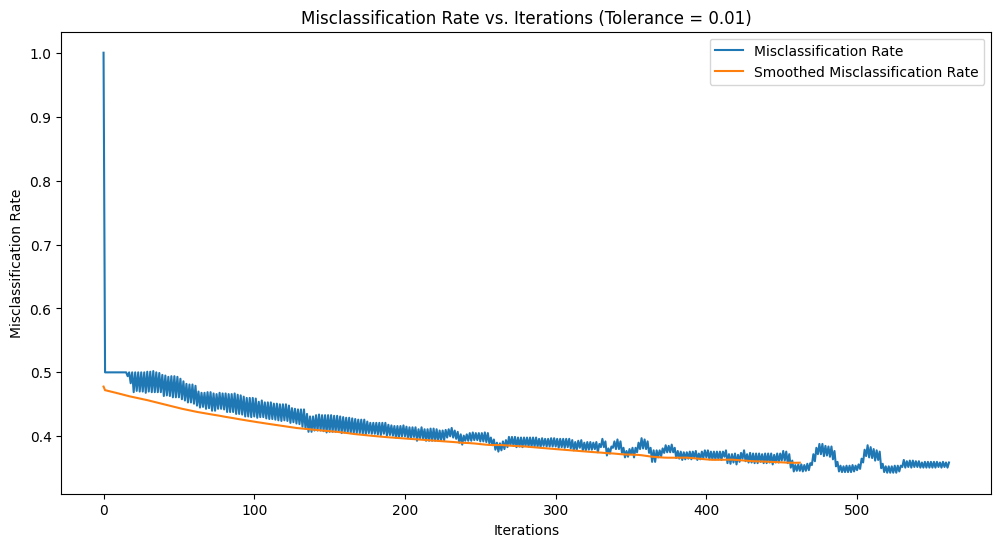

Converged: False, Iterations: 562


Training Iterations:   1%|          | 11667/1000000 [00:00<00:34, 29017.25it/s]

Loop detected after 11667 iterations. Stopping training.
Perceptron did not converge.


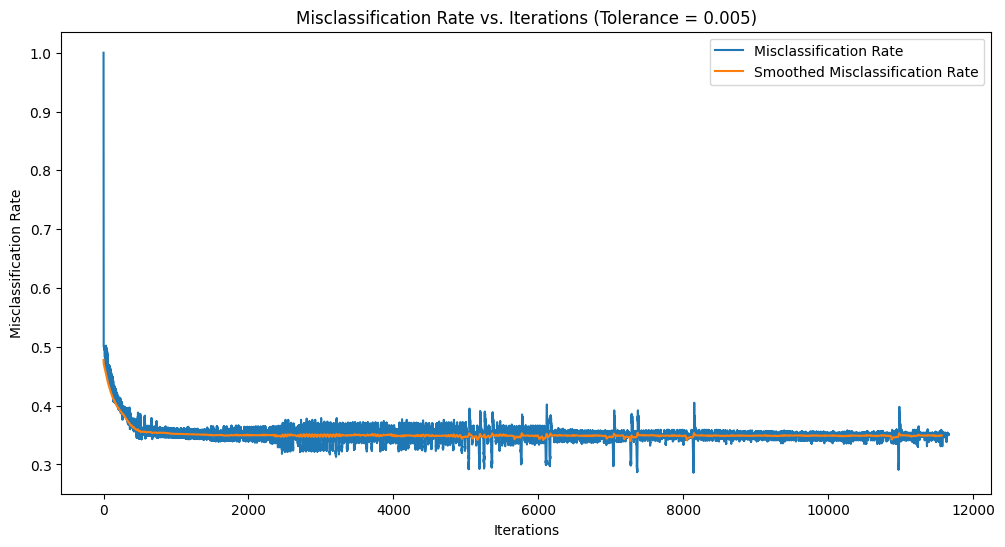

Converged: False, Iterations: 11667


Training Iterations:   1%|          | 11962/1000000 [00:00<00:32, 30227.46it/s]

Loop detected after 11962 iterations. Stopping training.
Perceptron did not converge.


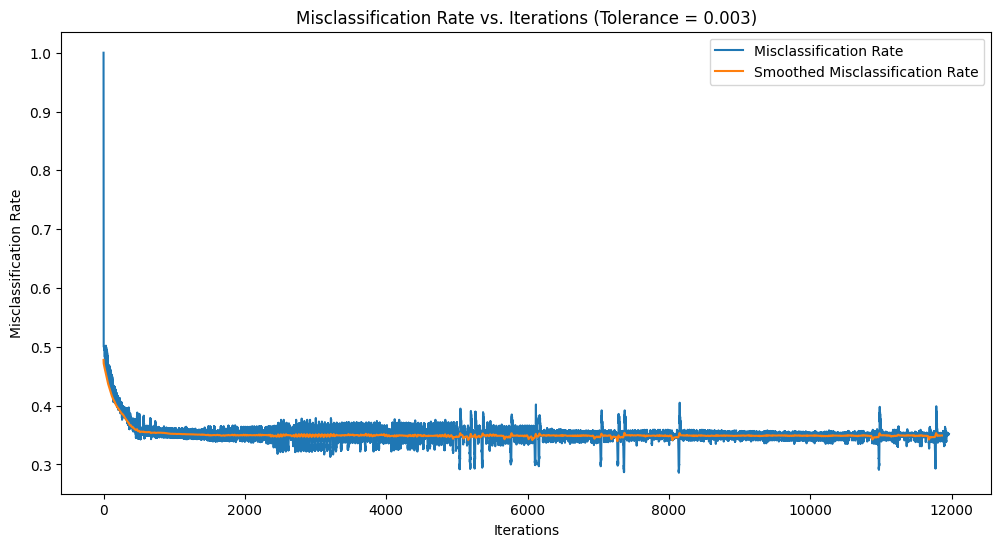

Converged: False, Iterations: 11962


Training Iterations:  19%|█▉        | 191851/1000000 [00:06<00:27, 29479.93it/s]


KeyboardInterrupt: 

In [8]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque

def plot_misclassification_rate(misclassification_rate_history, smoothed_rate, tolerance=0.001):
    plt.figure(figsize=(12, 6))
    plt.plot(misclassification_rate_history, label="Misclassification Rate")
    plt.plot(smoothed_rate, label="Smoothed Misclassification Rate")
    plt.title(f"Misclassification Rate vs. Iterations (Tolerance = {tolerance})")  # Updated title
    plt.xlabel("Iterations")
    plt.ylabel("Misclassification Rate")
    plt.legend()
    plt.show()

def detect_loop(recent_rates, tolerance=0.001):
    if len(recent_rates) < 20:
        return False
    min_rate, max_rate = min(recent_rates), max(recent_rates)
    return (max_rate - min_rate) < tolerance  # Small variation indicates a loop

def train_perceptron(train_data, max_iterations=1000000, window_size=100, tolerance = 0.001):
    w_star = np.zeros(27,)
    training_iteration = 0
    misclassification_rate_history = []
    recent_rates = deque(maxlen=20)  # Store last 20 rates for loop detection
    
    with tqdm.tqdm(total=max_iterations, desc="Training Iterations") as pbar:
        while training_iteration < max_iterations:
            converged = True
            training_iteration += 1
            pbar.update(1)

            feature_matrix = np.vstack([instance[0] for instance in train_data])
            label_vector = np.hstack([instance[1] for instance in train_data])

            predictions = label_vector * np.dot(feature_matrix, w_star)
            misclassified_indices = np.where(predictions <= 0)[0]
            
            if len(misclassified_indices) > 0:
                converged = False
                misclassified_features = feature_matrix[misclassified_indices]
                misclassified_labels = label_vector[misclassified_indices].reshape(-1, 1)
                w_star += np.sum(misclassified_features * misclassified_labels, axis=0)

            # Compute misclassification rate
            total_samples = len(label_vector)
            misclassification_rate = len(misclassified_indices) / total_samples
            misclassification_rate_history.append(misclassification_rate)
            recent_rates.append(misclassification_rate)

            # Check for looping behavior
            if detect_loop(recent_rates, tolerance):
                print(f"Loop detected after {training_iteration} iterations. Stopping training.")
                break

            if misclassification_rate == 0:
                print("Perceptron converged.")
                smoothed_rate = np.convolve(misclassification_rate_history, np.ones(window_size)/window_size, mode='valid')
                plot_misclassification_rate(misclassification_rate_history, smoothed_rate)
                return w_star, True, training_iteration

    print("Perceptron did not converge.")
    
    # Apply rolling average smoothing
    smoothed_rate = np.convolve(misclassification_rate_history, np.ones(window_size)/window_size, mode='valid')
    
    plot_misclassification_rate(misclassification_rate_history, smoothed_rate, tolerance)
    return w_star, False, training_iteration


tolerance = [0.01, 0.005, 0.003, 0.001]
for tol in tolerance:
    ret_per, converged, training_iterations = train_perceptron(train_data, tolerance=tol)
    print(f'Converged: {converged}, Iterations: {training_iterations}')



In [ ]:
def test_perceptron(train_data, train_labels, w_star):
    feature_matrix = np.vstack([instance[0] for instance in train_data])
    label_vector = np.hstack([instance[1] for instance in train_data])
    predictions = np.sign(np.dot(feature_matrix, w_star))
    misclassified_indices = np.where(predictions != label_vector)[0]
    misclassification_rate = len(misclassified_indices) / len(label_vector)
    return misclassification_rate

misclassification_rate = test_perceptron(train_data, train_labels, ret_per)
print(f'Misclassification Rate on Training Data: {misclassification_rate}')

Misclassification Rate on Training Data: 0.345


In [ ]:
from cvxopt import matrix, solvers
import numpy as np
import time

train_features = train_data[0][0]
train_labels = train_data[0][1]


def solve_svm_primal(train_features, train_labels, C=1.0):
    n_samples, n_features = train_features.shape
    dec_var_num = n_features + 1 + n_samples  # w + b + ξ_i

    # Quadratic term: 1/2 * w^T * w
    P = np.zeros((dec_var_num, dec_var_num))
    P[:n_features, :n_features] = np.eye(n_features)
    P = matrix(P)
    
    # Linear term: C * Σξ_i
    q = np.zeros(dec_var_num)
    q[n_features + 1:] = C
    q = matrix(q)
    
    # Inequality constraints: y_i(w^T * x_i + b) >= 1 - ξ_i and ξ_i >= 0
    G = np.zeros((2 * n_samples, dec_var_num))  # 2 constraints per sample
    h = np.zeros(2 * n_samples)
    
    for i in range(n_samples):
        G[i, :n_features] = -train_labels[i] * train_features[i]  # -y_i * x_i
        G[i, n_features] = -train_labels[i]  # -y_i for bias term
        G[i, n_features + 1 + i] = -1.0  # -ξ_i
        h[i] = -1.0  # -1 constraint
        G[n_samples + i, n_features + 1 + i] = -1.0  # -ξ_i <= 0
        h[n_samples + i] = 0.0  # 0 constraint
    
    G = matrix(G)
    h = matrix(h)
    
    solvers.options['show_progress'] = False
    
    start_time = time.time()
    svm_primal_solution = solvers.qp(P, q, G, h)
    end_time = time.time()
    
    return svm_primal_solution, end_time - start_time
# Primal Problem Solver
C = 1
n_features = train_features.shape[1]
svm_primal_solution, time_taken = solve_svm_primal(train_features, train_labels, C)
w_primal = np.array(svm_primal_solution['x'][:n_features]).flatten() # w vector
b_primal = float(svm_primal_solution['x'][n_features]) # bias term
ξ_primal = np.array(svm_primal_solution['x'][n_features + 1:])
ξ_primal = np.maximum(ξ_primal, 0) # slack variables
print(f'w_primal: {w_primal}')
print(f'b_primal: {b_primal}')
print(f'ξ_primal: {ξ_primal}')


w_primal: [-0.78591268 -2.12334747 -0.51138556 -0.63228703 -0.04313615  0.0431137
 -0.46228146  0.85529173 -0.27153631  0.81877894 -0.86993204  0.8774079
 -0.4708968  -0.22129767 -0.13846109  0.94233785  2.92327358  1.42692106
  2.73284578  1.41331582  2.77895495 -1.71236178 -0.34358426 -2.05455949
 -2.03272551 -0.16772966 -2.84762008]
b_primal: -0.0856464384072866
ξ_primal: [[5.77417361e-01]
 [1.09130559e-07]
 [1.12796924e-07]
 [1.31936852e+00]
 [1.06015533e-07]
 [1.12455252e-07]
 [1.10161300e-07]
 [5.96883270e-01]
 [6.21508476e-01]
 [5.45323652e-01]
 [7.46788570e-01]
 [2.42504659e+00]
 [5.33881285e-01]
 [1.17163380e+00]
 [2.21019588e-01]
 [1.15989695e-07]
 [9.06705162e-01]
 [1.11130185e-07]
 [1.09332512e-07]
 [1.96479049e+00]
 [1.10616146e-07]
 [3.21705959e-01]
 [1.22792748e+00]
 [1.11544183e-07]
 [1.24924834e+00]
 [1.17104653e-07]
 [1.48503799e-05]
 [1.10008194e-07]
 [1.05810256e-01]
 [6.45922322e-01]
 [1.00662159e+00]
 [3.63021779e-01]
 [1.10512724e-07]
 [4.56535349e-01]
 [2.744229

In [ ]:
def linear_kernel(x1, x2, gamma=0):
    return np.dot(x1, x2.T)

def solve_svm_dual(train_features, train_labels, C = 1.0, kernel=linear_kernel, gamma = 0):
    # We convert the dual problem to a quadratic minimisation problem
    n_samples = train_features.shape[0]
    
    # Quadratic Term P_ij = y_i * y_j * K(x_i, x_j)
    P = np.outer(train_labels, train_labels) * kernel(train_features, train_features, gamma)
    P = matrix(P)
    
    # Linear Term q_i = -1
    q = -np.ones(n_samples)
    q = matrix(q)
    
    # Inequality constraints: 0 ≤ α ≤ C
    G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
    h = np.hstack((np.zeros(n_samples), np.full(n_samples, C)))
    G = matrix(G)
    h = matrix(h)
    
    # Equality constraint: Σ α_i * y_i = 0
    A = np.zeros(n_samples)
    for i in range(n_samples):
        A[i] = train_labels[i]
    A = matrix(A, (1, n_samples))
    b = matrix(0.0)
    
    solvers.options['show_progress'] = False
    
    # Solve the SVM dual problem
    start_time = time.time()
    solution = solvers.qp(P, q, G, h, A, b)
    end_time = time.time()
    
    
    return solution, end_time - start_time

C = 1
svm_dual_solution, time_taken = solve_svm_dual(train_features, train_labels, C)
α = np.array(svm_dual_solution['x']).flatten()  # Lagrange multipliers
# w = Σ α_i * y_i * x_i
w_dual = np.dot(α * train_labels, train_features)
# Compute Support Vectors
support_vector_indices = (α > 1e-5) & (α < C-1e-5)

support_vectors = train_features[support_vector_indices]
support_vector_labels = train_labels[support_vector_indices]
    
if support_vectors.shape[0] == 0:
    print("No support vectors found. Try adjusting C or using a different kernel.")

b_dual = np.mean(support_vector_labels - np.dot(support_vectors, w_dual))
    
# ξ_i = max(0, 1 - y_i * (w^T * x_i + b))
ξ_dual = np.maximum(0, 1 - support_vector_labels * (np.dot(w_dual, support_vectors.T) + b_dual))

print(f'w: {w_dual}')
print(f'b: {b_dual}')
print(f'ξ: {ξ_dual}')


        

    

w: [-0.78591268 -2.12334747 -0.51138556 -0.63228703 -0.04313615  0.0431137
 -0.46228146  0.85529173 -0.27153631  0.81877894 -0.86993204  0.8774079
 -0.4708968  -0.22129767 -0.13846109  0.94233785  2.92327358  1.42692106
  2.73284578  1.41331582  2.77895495 -1.71236178 -0.34358426 -2.05455949
 -2.03272551 -0.16772966 -2.84762008]
b: -0.08557118731439652
ξ: [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.06685691e-03
 1.59825239e-03 7.52348952e-05 7.48661743e-05 1.41186889e-02
 7.98259736e-05 0.00000000e+00 7.53691281e-05 7.56196735e-05
 7.64375290e-05 0.00000000e+00 7.52312984e-05 0.00000000e+00
 7.69935800e-05 0.00000000e+00]


Solving SVM Problem for C = 0.1
Solving SVM Problem for C = 1.0
Solving SVM Problem for C = 10.0
Solving SVM Problem for C = 100.0


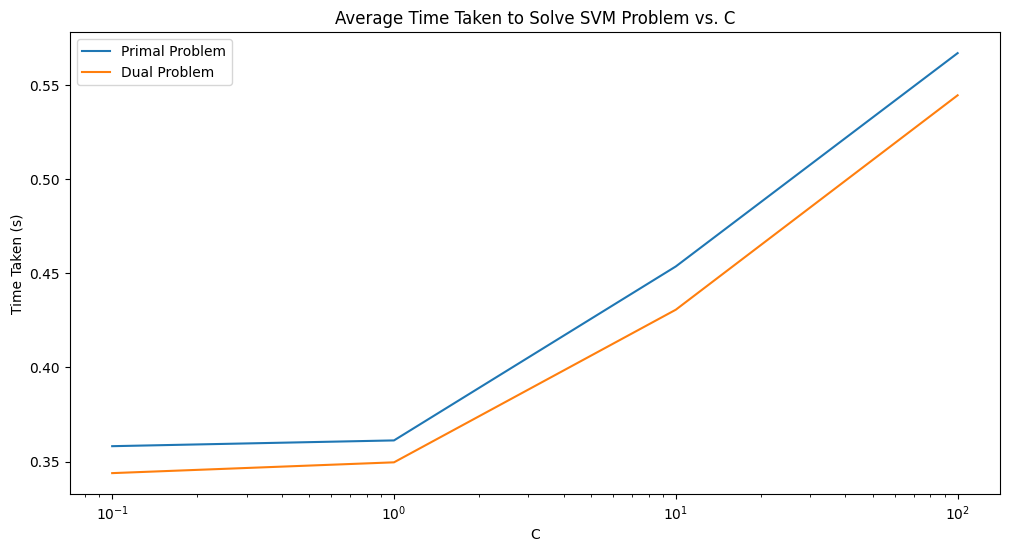

In [ ]:
C_values = [0.1, 1.0, 10.0, 100.0]

time_values_dual = []
time_values_primal = []

for C in C_values:
    print(f"Solving SVM Problem for C = {C}")
    average_time_taken_primal = 0
    average_time_taken_dual = 0
    
    for iter in range(20):
        _, time_taken_primal = solve_svm_primal(train_features, train_labels, C)
        _, time_taken_dual = solve_svm_dual(train_features, train_labels, C)
        
        average_time_taken_primal += time_taken_primal
        average_time_taken_dual += time_taken_dual
        
    average_time_taken_primal /= 20
    average_time_taken_dual /= 20
    
    time_values_primal.append(average_time_taken_primal)
    time_values_dual.append(average_time_taken_dual)

# I want to plot a comparision plot between times of dual and primal
plt.figure(figsize=(12, 6))
plt.plot(C_values, time_values_primal, label="Primal Problem")
plt.plot(C_values, time_values_dual, label="Dual Problem")
plt.title("Average Time Taken to Solve SVM Problem vs. C")
plt.xlabel("C")
plt.ylabel("Time Taken (s)")
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
import numpy as np
def compute_misclassified_indices(w, b, features, labels):
    misclassified_indices = []
    for i in range(len(features)):
        if labels[i] * (np.dot(w, features[i]) + b) <= 0:
            misclassified_indices.append(i)
    return misclassified_indices

primal_misclassified_indices = compute_misclassified_indices(w_primal, b_primal, train_features, train_labels)
dual_misclassified_indices = compute_misclassified_indices(w_dual, b_dual, train_features, train_labels)
print(f'Primal Misclassified Indices: {primal_misclassified_indices}')
print(f'Dual Misclassified Indices: {dual_misclassified_indices}')
print(f"Primal Misclassfication Rate: {len(primal_misclassified_indices) / len(train_labels)}")
print(f"Dual Misclassfication Rate: {len(dual_misclassified_indices) / len(train_labels)}")
np.savetxt('inseperable_23882.csv', primal_misclassified_indices, delimiter=',')




Primal Misclassified Indices: [3, 11, 13, 19, 22, 24, 30, 36, 37, 38, 42, 43, 45, 46, 55, 56, 57, 58, 60, 65, 70, 79, 83, 86, 88, 89, 94, 95, 98, 99, 105, 106, 113, 119, 128, 130, 133, 139, 142, 144, 145, 146, 156, 158, 164, 165, 170, 172, 174, 179, 180, 182, 184, 187, 193, 198, 200, 203, 209, 213, 221, 237, 238, 241, 245, 249, 250, 258, 261, 264, 266, 268, 271, 277, 280, 286, 288, 297, 302, 306, 307, 309, 312, 313, 327, 331, 336, 341, 342, 344, 345, 347, 349, 350, 353, 369, 371, 373, 374, 378, 382, 390, 392, 394, 403, 404, 405, 406, 409, 415, 424, 425, 433, 434, 439, 440, 445, 446, 447, 451, 471, 472, 476, 483, 486, 489, 491, 499, 500, 505, 507, 510, 520, 523, 529, 532, 539, 540, 541, 546, 562, 563, 564, 577, 581, 584, 585, 596, 598, 604, 607, 612, 614, 617, 618, 624, 629, 630, 631, 635, 636, 640, 642, 643, 648, 654, 658, 669, 682, 683, 684, 689, 691, 693, 695, 705, 706, 710, 712, 715, 722, 726, 734, 736, 746, 752, 756, 761, 764, 765, 766, 767, 770, 778, 782, 784, 788, 789, 795, 796, 

In [ ]:
from itertools import product
def rbf_kernel(x1, x2, gamma=0.1):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

C = 1.0

def svm_gaussain_predictor(α_gaussian, support_vectors, support_vector_labels, b, gamma, x):
    prediction = b
    for i in range(len(support_vectors)):
        prediction += α_gaussian[i] * support_vector_labels[i] * rbf_kernel(support_vectors[i], x, gamma)
    return prediction

def compute_gaussian_b(α_gaussian, support_vectors, support_vector_labels, gamma):
    b_values = []
    for i in range(len(support_vectors)):
        b_i = support_vector_labels[i]
        for j in range(len(support_vectors)):
            b_i -= α_gaussian[j] * support_vector_labels[j] * rbf_kernel(support_vectors[j], support_vectors[i], gamma)
        b_values.append(b_i)
    return np.mean(b_values)

def compute_gaussian_misclassified_indices(α_gaussian, support_vectors, support_vector_labels, b, gamma, features, labels):
    misclassified_indices = []
    for i in range(len(features)):
        prediction = svm_gaussain_predictor(α_gaussian, support_vectors, support_vector_labels, b, gamma, features[i])
        if labels[i] * prediction <= 0:
            misclassified_indices.append(i)
    return misclassified_indices


C_values = [0.1, 1.0, 10.0, 100.0, 1000.0]
gamma_values = [0.1, 1.0, 5, 10.0, 20, 30, 50.0, 100.0]

best_C, best_gamma = None, None
best_misclassification_rate = 1.0

for C, gamma in product(C_values, gamma_values):
    print(f"Training SVM with C={C}, Gamma={gamma}")
    svm_dual_solution, time_taken = solve_svm_dual(train_features, train_labels, C, kernel=rbf_kernel, gamma=gamma)
    α_gaussian = np.array(svm_dual_solution['x']).flatten()  # Lagrange multipliers
    
    
    support_vector_indices = np.where((α_gaussian > 1e-5) & (α_gaussian < C - 1e-5))[0]
    if len(support_vector_indices) == 0:
        continue
    support_vectors = train_features[support_vector_indices]
    support_vector_labels = train_labels[support_vector_indices]

    b_gaussian_dual = compute_gaussian_b(α_gaussian, support_vectors, support_vector_labels, gamma)
    
    gaussain_misclassified_rate = len(compute_gaussian_misclassified_indices(α_gaussian, support_vectors, support_vector_labels, b_gaussian_dual, gamma, train_features, train_labels)) / len(train_labels)
    print(f"C: {C}, Gamma: {gamma}, Misclassification Rate: {gaussain_misclassified_rate}")
    
    if gaussain_misclassified_rate < best_misclassification_rate:
        best_misclassification_rate = gaussain_misclassified_rate
        best_C = C
        best_gamma = gamma

print(f"Best C: {best_C}, Best Gamma: {best_gamma}, Best Misclassification Rate: {best_misclassification_rate}")






Training SVM with C=0.1, Gamma=0.1
Training SVM with C=0.1, Gamma=1.0
Training SVM with C=0.1, Gamma=5
Training SVM with C=0.1, Gamma=10.0
Training SVM with C=0.1, Gamma=20
Training SVM with C=0.1, Gamma=30
Training SVM with C=0.1, Gamma=50.0
Training SVM with C=0.1, Gamma=100.0
Training SVM with C=1.0, Gamma=0.1
Training SVM with C=1.0, Gamma=1.0
Training SVM with C=1.0, Gamma=5
Training SVM with C=1.0, Gamma=10.0
Training SVM with C=1.0, Gamma=20
Training SVM with C=1.0, Gamma=30
Training SVM with C=1.0, Gamma=50.0
Training SVM with C=1.0, Gamma=100.0
Training SVM with C=10.0, Gamma=0.1
Training SVM with C=10.0, Gamma=1.0
Training SVM with C=10.0, Gamma=5
Training SVM with C=10.0, Gamma=10.0
Training SVM with C=10.0, Gamma=20
Training SVM with C=10.0, Gamma=30
Training SVM with C=10.0, Gamma=50.0
Training SVM with C=10.0, Gamma=100.0
Training SVM with C=100.0, Gamma=0.1
C: 100.0, Gamma: 0.1, Misclassification Rate: 0.346
Training SVM with C=100.0, Gamma=1.0
C: 100.0, Gamma: 1.0, Misc

757 757


Training Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Perceptron converged.


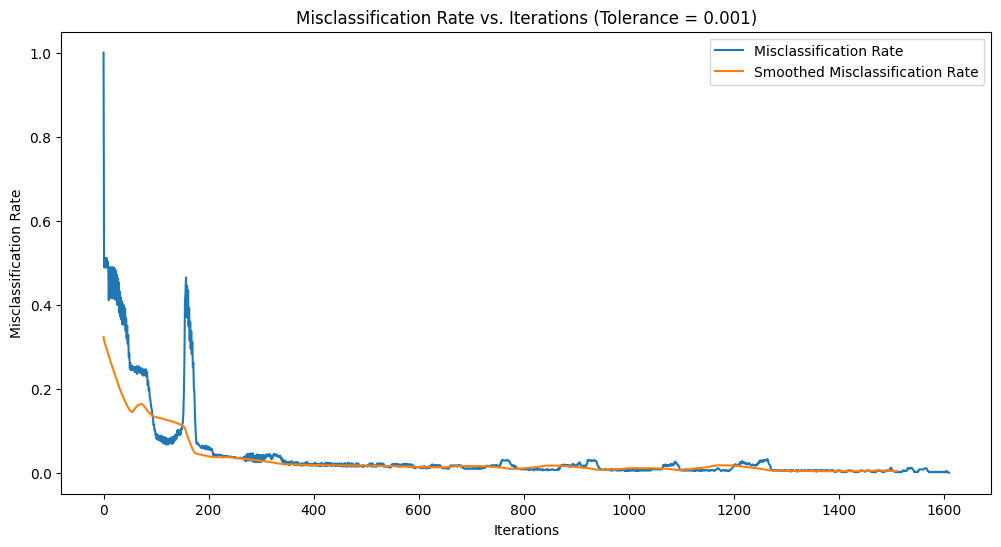

Training Iterations:   0%|          | 1611/1000000 [00:00<01:02, 15898.06it/s]

Converged: True, Iterations: 1611


In [ ]:
# Remove the misclassified indices from the training data identified by linear SVM and retrain the SVM model
seperable_train_features = np.delete(train_features, primal_misclassified_indices, axis=0)
seperable_train_labels = np.delete(train_labels, primal_misclassified_indices)
print(len(seperable_train_features), len(seperable_train_labels))

seperable_data = [[seperable_train_features, seperable_train_labels]]

ret_per, converged, training_iterations = train_perceptron(seperable_data)
print(f'Converged: {converged}, Iterations: {training_iterations}')
